<a href="https://colab.research.google.com/github/PiyushiAnand/FinSearch_RL/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Load the training data into a Pandas DataFrame.
train_data = pd.read_excel("HistoricalPrices-3.xlsx")

# Load the testing data into a Pandas DataFrame.
test_data = pd.read_csv("NIFTY 50.csv")

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.iloc[:, 4].values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.iloc[:, 4].values.reshape(-1, 1))

In [5]:
# Define the state function
def get_state(state_index, data):
    lookback_window = 5  # Number of previous time steps to consider
    start_index = max(0, state_index - lookback_window)
    end_index = state_index + 1
    state = data[start_index:end_index].flatten()
    return state

In [6]:
# Define the actions
num_actions = 2  # Buy (1) or Hold (0)
action_mapping = {0: 'Hold', 1: 'Buy'}

# Create a Q-table, which is a table that stores the Q-values for each state-action pair.
num_train_states = train_data_normalized.shape[0]
num_test_states = test_data_normalized.shape[0]
q_table = torch.zeros((num_train_states, num_actions))
# Initialize the Q-table with random values.
nn.init.xavier_uniform_(q_table)

tensor([[-1.3077e-02,  3.1677e-02],
        [ 1.5030e-02, -1.8669e-02],
        [-3.8852e-02, -3.3746e-02],
        ...,
        [ 1.6238e-02,  4.8722e-02],
        [-5.0054e-02,  2.5812e-05],
        [-3.2490e-02,  4.0486e-02]])

In [7]:
# Define the epsilon-greedy policy
def epsilon_greedy_policy(state, q_table, epsilon):
    if random.random() < epsilon:
        action = random.randint(0, num_actions - 1)
    else:
        action = torch.argmax(q_table[state])
    return action

In [8]:
# Define the Bellman equation
def bellman_equation(state, action, reward, next_state_index, q_table):
    if next_state_index < num_train_states:
        next_state = torch.tensor([next_state_index])
        target = reward + gamma * torch.max(q_table[next_state])
    else:
        target = reward
    q_table[state, action] = target

In [9]:
# Training phase
num_epochs = 30
epsilon = 1.0
gamma = 0.98
replay_buffer = []
batch_size = 32
target_update_freq = 10
target_q_table = q_table.clone()

for i in range(num_epochs):
    for state in range(num_train_states - 1):
        current_state = get_state(state, train_data_normalized)
        action = epsilon_greedy_policy(state, q_table, epsilon)
        reward = train_data_normalized[state + 1].item()  # Convert tensor to a Python scalar
        next_state_index = state + 1
        bellman_equation(state, action, reward, next_state_index, q_table)

        # Store experience in replay buffer
        replay_buffer.append((current_state, action, reward, next_state_index))

        # Perform experience replay
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            for batch_current_state, batch_action, batch_reward, batch_next_state_index in batch:
                bellman_equation(batch_current_state, batch_action, batch_reward, batch_next_state_index, q_table)

    # Update target Q-table
    if i % target_update_freq == 0:
        target_q_table = q_table.clone()

    # Decay epsilon
    epsilon *= 0.70

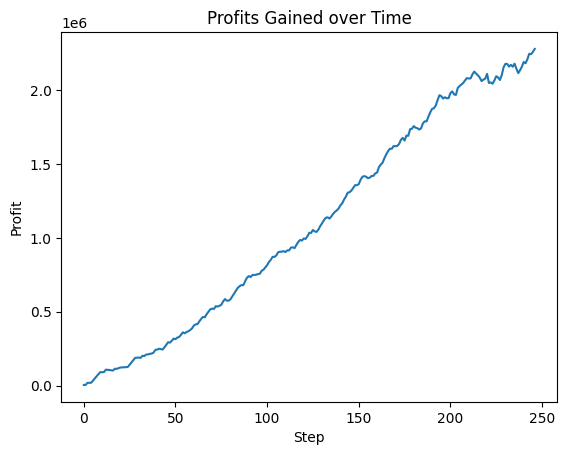

In [10]:
# Testing phase
shares = 0
portfolio = 10000
profits = []
for state in range(num_test_states - 1):
    current_state = get_state(state, test_data_normalized)
    action = torch.argmax(q_table[state])
    if action == 1:
        shares += 1
    profit = scaler.inverse_transform([test_data_normalized[state + 1]]) * shares - portfolio
    profits.append(profit)

# Flatten the profits list
flattened_profits = [item for sublist in profits for item in sublist]

# Visualize the results
plt.plot(flattened_profits)
plt.xlabel('Step')
plt.ylabel('Profit')
plt.title('Profits Gained over Time')
plt.show()